# Introduction to the xgbsurv package - AFT

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import load_metabric
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
current_path = os.getcwd() 
one_level_up = os.path.abspath(os.path.join(current_path,  ".."))

## Load Data

In [2]:
data = load_metabric(path=one_level_up+"/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

Values are being sorted!
Values are being sorted!


## Load Model

In [3]:
model = XGBSurv(n_estimators=100, objective="aft_objective",
                                             eval_metric="aft_loss",
                                             learning_rate=0.3,
                                             random_state=42, 
                                             disable_default_eval_metric=1,
                                             )
model

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x28fe0c360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2a00439c0>), ...)

The options of loss and objective functions can be obtained like below:

In [4]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [5]:
eval_set = [(X_train, y_train)]

In [6]:
model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-aft_likelihood:2544.48974
[1]	validation_0-aft_likelihood:2519.20841
[2]	validation_0-aft_likelihood:2493.05942
[3]	validation_0-aft_likelihood:2468.12801
[4]	validation_0-aft_likelihood:2444.77146
[5]	validation_0-aft_likelihood:2419.77697
[6]	validation_0-aft_likelihood:2394.45945
[7]	validation_0-aft_likelihood:2375.18752
[8]	validation_0-aft_likelihood:2347.46956
[9]	validation_0-aft_likelihood:2318.75660
[10]	validation_0-aft_likelihood:2299.22171
[11]	validation_0-aft_likelihood:2281.01238
[12]	validation_0-aft_likelihood:2267.74981
[13]	validation_0-aft_likelihood:2253.95432
[14]	validation_0-aft_likelihood:2237.00974
[15]	validation_0-aft_likelihood:2223.04365
[16]	validation_0-aft_likelihood:2217.67512
[17]	validation_0-aft_likelihood:2208.10002
[18]	validation_0-aft_likelihood:2197.81936
[19]	validation_0-aft_likelihood:2181.23658
[20]	validation_0-aft_likelihood:2168.14106
[21]	validation_0-aft_likelihood:2158.85753
[22]	validation_0-aft_likelihood:2154.4399

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x28fe0c360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2a00439c0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [7]:
#model.save_model("introduction_model_breslow.json")

## Predict

In [8]:
preds_train = model.predict(X_train, output_margin=True)
preds_test = model.predict(X_test, output_margin=True)

### Predict Cumulative Hazard

In [9]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
335.733337,0.632305,3.939879,3.177861,0.393528,0.800501,1.020239,6.032359,2.000150,4.705243,0.553711,...,2.037321,3.985135,0.376771,5.932850,2.924134,0.455359,3.586049,1.394158,5.727282,5.323738
351.000000,0.698887,4.207121,3.433460,0.415645,0.890815,1.136586,6.032470,2.198890,4.948664,0.607564,...,2.238591,4.251966,0.394913,5.969167,3.169672,0.490846,3.851651,1.547113,5.822961,5.500202
355.200012,0.718338,4.277973,3.503292,0.422360,0.916862,1.169865,6.032492,2.254111,5.011583,0.623354,...,2.294192,4.322649,0.400495,5.976834,3.238539,0.501446,3.923131,1.590222,5.844386,5.543854


## Predict Survival Function

In [10]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
335.733337,0.531365,0.019451,0.041675,0.674672,0.449104,0.360509,0.0024,0.135315,0.009048,0.574813,...,0.130377,0.018590,0.686073,0.002651,0.053711,0.634220,0.027708,0.248042,0.003256,0.004874
351.000000,0.497138,0.014889,0.032275,0.659914,0.410321,0.320913,0.0024,0.110926,0.007093,0.544676,...,0.106609,0.014236,0.673739,0.002556,0.042017,0.612109,0.021245,0.212862,0.002959,0.004086
355.200012,0.487562,0.013871,0.030098,0.655498,0.399772,0.310409,0.0024,0.104967,0.006660,0.536143,...,0.100843,0.013265,0.669988,0.002537,0.039221,0.605654,0.019779,0.203880,0.002896,0.003911


### Visualize Predictions

Text(0.5, 1.0, 'Cumulative Hazard Breslow')

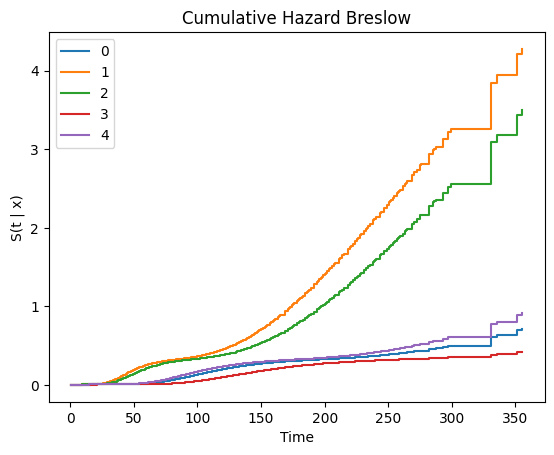

In [11]:
df_cum_hazards.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Cumulative Hazard Breslow")

Text(0.5, 1.0, 'Survival Curve Breslow')

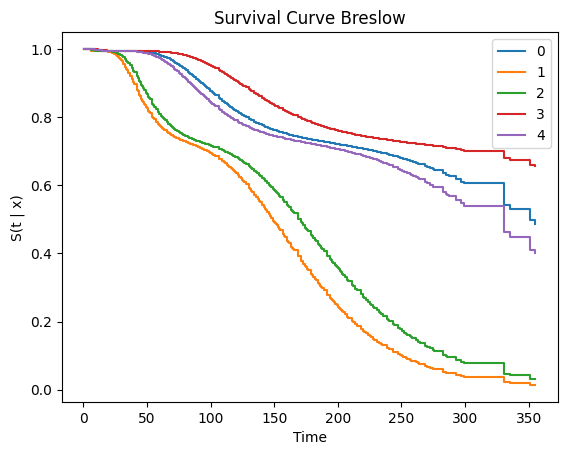

In [12]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Breslow")

## Evaluate

### Test

In [13]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.5975628527449974


In [14]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.21278237756672985
